In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import os
# os.chdir("../../pykan/kan/")
from Scaled_KAN import *

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size_train = 32
batch_size_test = 32
lr = 1e-3
momentum = 0.8

tasks = 10

In [2]:
# Create conventional MLP model
class NN(nn.Module):

    def __init__(self):
        super(NN, self).__init__()
        # 28*28 input image, 64 output units, 10 output units
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        # Flatten the image
        x = x.view(-1, 28*28)
        # Pass through the first layer
        x = F.relu(self.fc1(x))
        # Pass through the second layer
        x = self.fc2(x)
        # Apply log softmax
        x = F.log_softmax(x, dim=1)
        return x

model = NN()
model.to(device)
print(f"Conventional model: {model}")

# Create KAN model
KAN_model = FastKAN(layers_hidden=[28*28,64,10], grid_min=3, grid_max=5, device=device)
KAN_model.to(device)

print(f"KAN model: {KAN_model}")

Conventional model: NN(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
KAN model: FastKAN(
  (layers): ModuleList(
    (0): FastKANLayer(
      (layernorm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=6272, out_features=64, bias=False)
      (base_linear): Linear(in_features=784, out_features=64, bias=True)
    )
    (1): FastKANLayer(
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=512, out_features=10, bias=False)
      (base_linear): Linear(in_features=64, out_features=10, bias=True)
    )
  )
)


In [3]:
import numpy as np
model = KAN_model
# Transform the MNIST dataset to a tensor and normalising it
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.1307),(0.3081)), # Normalise samples using the mean of 0.1307 and std of 0.3081 - extracted after manual analysis
    T.Lambda(lambda x: torch.flatten(x))
])
train_set = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_set = datasets.MNIST('../data', train=False, download=True, transform=transform)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=momentum)

loss_fn = nn.CrossEntropyLoss()

# Pair numbers together and create 5 tasks
tasks = [(i,i+1) for i in range(0,10,2)]

# For training: fill splitted_train array with examples where the target value is in task i
targets = train_set.targets.numpy()
splitted_train = []
for task in tasks:
    indices = np.where(np.isin(targets, task))[0]
    subset = [train_set[i] for i in indices]
    splitted_train.append(subset)

# For testing: fill splitted_train array with examples where the target value is in task i
targets = test_set.targets.numpy()
splitted_test = []
for task in tasks:
    indices = np.where(np.isin(targets, task))[0]
    subset = [test_set[i] for i in indices]
    splitted_test.append(subset)


torch.Size([784])


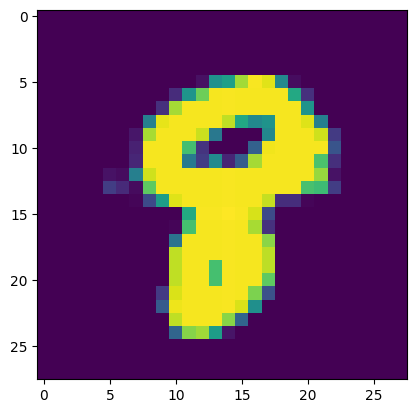

In [4]:
# Visualise a random image to check if the data is loaded correctly
rand_image = random.choice(splitted_train[4])
print(rand_image[0].shape)
plt.imshow(rand_image[0].numpy().reshape(28,28))
plt.show()

In [5]:

# Train the KAN
performance = []
for task in range(len(tasks)):
    print(f"Training on {task}")

    # Create dataloader with the splitted training and testing sets
    train_loader = torch.utils.data.DataLoader(
        splitted_train[task],
        batch_size=batch_size_train,
        shuffle=True
    )

    # Accumulate testing samples into performance array to evaluate forgetting of previous tasks
    performance.extend(splitted_test[task])
    
    test_loader = torch.utils.data.DataLoader(
        performance, 
        batch_size=batch_size_test, 
        shuffle=True
    )

    # # Visualise a random image to check if the data is loaded correctly
    # rand_image = random.choice(performance)
    # print(rand_image[0][0].shape)
    # plt.imshow(rand_image[0][0].numpy().reshape(28,28))
    # plt.show()
    
    print(len(train_loader.dataset), len(test_loader.dataset))
    
    for epoch in range(10):
        # Train the model
        model.train()
        train_loss = 0
        correct = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        model.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += loss_fn(output, target).item() * data.size(0)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        test_acc = correct / len(test_loader.dataset)

        # Update the learning rate
        scheduler.step()
        print(f'Epoch {epoch+1} train/test accuracy: {train_acc:.2f}/{test_acc:.2f}')

    # Use evaluation plugin to evaluate the model
    

torch.save(model.state_dict(), "mnist_model.pth")

Training on 0
12665 2115
Epoch 1 train/test accuracy: 1.00/1.00
Epoch 2 train/test accuracy: 1.00/1.00
Epoch 3 train/test accuracy: 1.00/1.00
Epoch 4 train/test accuracy: 1.00/1.00
Epoch 5 train/test accuracy: 1.00/1.00
Epoch 6 train/test accuracy: 1.00/1.00
Epoch 7 train/test accuracy: 1.00/1.00
Epoch 8 train/test accuracy: 1.00/1.00
Epoch 9 train/test accuracy: 1.00/1.00
Epoch 10 train/test accuracy: 1.00/1.00
Training on 1
12089 4157
Epoch 1 train/test accuracy: 0.91/0.59
Epoch 2 train/test accuracy: 0.97/0.55
Epoch 3 train/test accuracy: 0.98/0.53
Epoch 4 train/test accuracy: 0.98/0.52
Epoch 5 train/test accuracy: 0.98/0.51
Epoch 6 train/test accuracy: 0.98/0.51
Epoch 7 train/test accuracy: 0.98/0.51
Epoch 8 train/test accuracy: 0.98/0.51
Epoch 9 train/test accuracy: 0.98/0.50
Epoch 10 train/test accuracy: 0.99/0.50
Training on 2
11263 6031
Epoch 1 train/test accuracy: 0.04/0.58
Epoch 2 train/test accuracy: 0.54/0.70
Epoch 3 train/test accuracy: 0.84/0.66
Epoch 4 train/test accurac

In [10]:
model = FastKAN(layers_hidden=[28*28,64,10], grid_min=3, grid_max=5, device=device)
model.load_state_dict(torch.load("mnist_model.pth"))
model.to(device)
model.eval()

FastKAN(
  (layers): ModuleList(
    (0): FastKANLayer(
      (layernorm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=6272, out_features=64, bias=False)
      (base_linear): Linear(in_features=784, out_features=64, bias=True)
    )
    (1): FastKANLayer(
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=512, out_features=10, bias=False)
      (base_linear): Linear(in_features=64, out_features=10, bias=True)
    )
  )
)

In [13]:
layers = []
for layer in model.modules():
    layers.append(layer)
    print("====> Layer ", layer)
layer = layers[1]
# # for i in range(layer.input_dim):
# for j in range(layer.output_dim):
#     # layer.set_curve(i, j, torch.tensor([0.0, 1.0, 0.0], device=device))
#     x, y = layer.plot_curve(0, j, num_pts=100, num_extrapolate_bins=3)
#     plt.plot(x.to('cpu').numpy(), y.to('cpu').numpy(), label=f"Last Layer, Input 0, Output {j}")
# # plt.legend()
# plt.show()

====> Layer  FastKAN(
  (layers): ModuleList(
    (0): FastKANLayer(
      (layernorm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=6272, out_features=64, bias=False)
      (base_linear): Linear(in_features=784, out_features=64, bias=True)
    )
    (1): FastKANLayer(
      (layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (rbf): RadialBasisFunction()
      (spline_linear): SplineLinear(in_features=512, out_features=10, bias=False)
      (base_linear): Linear(in_features=64, out_features=10, bias=True)
    )
  )
)
====> Layer  ModuleList(
  (0): FastKANLayer(
    (layernorm): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
    (rbf): RadialBasisFunction()
    (spline_linear): SplineLinear(in_features=6272, out_features=64, bias=False)
    (base_linear): Linear(in_features=784, out_features=64, bias=True)
  )
  (1): FastKANLayer(
    (layernorm): LayerNorm((64,), eps=

In [8]:
# for each pixel of the given input image, given a layer an input and an output, give me the gradient of the weights
def get_gradient(model, layer, input, output):
    model.zero_grad()
    output = model(input)
    output = F.softmax(output, dim=1)
    loss = F.cross_entropy(output, output)
    loss.backward()
    return layer.weight.grad

AttributeError: 'FastKANLayer' object has no attribute 'curve'